<a href="https://colab.research.google.com/github/navas604/Text-Mining-Image-Recognition/blob/main/HDT4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Universidad Galileo**
## **Maestría en Data Science**
## **Text Mining & Image Recognition**
## **Antonio Everardo Navas Contreras, 14003163**
## **29/08/2021**

---

## **HOJA DE TRABAJO 4**

---

### CARGAR LIBRERÍAS

In [1]:
import pandas as pd
import spacy
import numpy as np
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

### MODELOS DE LENGUAJE

In [ ]:
!python -m spacy download es_core_news_sm

In [3]:
import pkg_resources, imp
imp.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [4]:
nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load("es_core_news_sm")

### CARGAR EL DATASET

In [5]:
URL = 'training.1600000.processed.noemoticon.csv'
tweets_DF = pd.read_csv(URL, encoding='latin-1', usecols=[2, 4, 5] , names=['Timestamp', 'Username', 'Content'])
tweets_DF.head()

,Timestamp,Username,Content
0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
################################################### BORRAR ###################################################
#tweets_DF = tweets_DF.head(1000)

In [7]:
tweets_DF.shape

(1600000, 3)

### TOP 3 USUARIOS MAS POPULARES (MENCIONADOS)

In [8]:
pattern = re.compile(r'@\w+')

mentions = pd.DataFrame(sum([pattern.findall(x) for x in tweets_DF.Content],[])).value_counts().rename_axis('Mentions').reset_index(name='Counts')
top_3_mentions = mentions[:3]

print('Los 3 usuarios más populares son:\n')
top_3_mentions

Los 3 usuarios más populares son:



,Mentions,Counts
0,@mileycyrus,4500
1,@tommcfly,3887
2,@ddlovato,3467


### CORPUS

In [9]:
top_3_list = []
for user in range(len(top_3_mentions)):
  user_data = tweets_DF.loc[tweets_DF.Content.str.contains(top_3_mentions.Mentions[user])]
  user_data = user_data.reindex(columns = ['Content', 'Username', 'Timestamp'])
  user_data['Tweet_Length'] = user_data.Content.str.len() - len(top_3_mentions.Mentions[user] + ' ')
  top_3_list.append(user_data)

In [40]:
top_user1 = pd.DataFrame(top_3_list[0])
top_user1.head()

,Content,Username,Timestamp,Tweet_Length
1021,@mileycyrus hahaha dont be like that one time ...,kristenn_lynn,Mon Apr 06 23:30:57 PDT 2009,95
2014,"@mileycyrus i have the same problem, but it's ...",nathiuria,Tue Apr 07 00:45:20 PDT 2009,125
2073,@mileycyrus I guess counting sheep didn't work...,amyamoore,Tue Apr 07 00:49:07 PDT 2009,60
2080,@mileycyrus I would too if it meant spending a...,xdokkenx,Tue Apr 07 00:49:44 PDT 2009,88
2156,@mileycyrus AWWW u seriously have the cutest d...,XFearLessX,Tue Apr 07 00:56:41 PDT 2009,100


In [41]:
top_user2 = pd.DataFrame(top_3_list[1])
top_user2.head()

,Content,Username,Timestamp,Tweet_Length
1690,@tommcfly hey saw u guys play @ pushover..didn...,mcsteph94,Tue Apr 07 00:19:09 PDT 2009,128
1789,@tommcfly Good morning Tom! Why can't I send y...,mcflyholland,Tue Apr 07 00:26:52 PDT 2009,121
2514,@tommcfly did you know that johnsons baby use ...,ckstarlet,Tue Apr 07 01:23:07 PDT 2009,86
3029,"@dougiemcfly @tommcfly good morning guys, how ...",McFLYBelgium,Tue Apr 07 02:03:41 PDT 2009,98
3524,"@tommcfly hey, no chance of adding brighton or...",lilmissvik,Tue Apr 07 02:46:02 PDT 2009,121


In [42]:
top_user3 = pd.DataFrame(top_3_list[2])
top_user3.head()

,Content,Username,Timestamp,Tweet_Length
460,@ddlovato @David_Henrie ummmmm i cant find it.,toritor11,Mon Apr 06 22:51:34 PDT 2009,37
573,@ddlovato Do you hate us?? Please don't,lovatolover,Mon Apr 06 22:58:30 PDT 2009,30
7032,@ddlovato Wish that i could see it.. Thats th...,mariapersson,Tue Apr 07 07:02:58 PDT 2009,86
7089,"@ddlovato hey demi, wen are you and selena gon...",xxBEJEALOUSxx,Tue Apr 07 07:05:11 PDT 2009,69
8611,@ddlovato ahhhh i wish i could go to the dalla...,Julie_Dances,Fri Apr 17 20:31:31 PDT 2009,75


### NORMALIZACIÓN DE TEXTO

In [13]:
def normalizacion(corpus):
  newCorpus = []
  for doc in corpus:
      #newCorpus.append(re.sub(r'[^@\w+a-zA-Z0-9\s{1}áéíóúüñÁÉÍÓÚ]', '', doc).lower().strip().rstrip('\n').rstrip('\r\n'))
      temp = re.sub(r'@\w+', '', doc).lower().strip().rstrip('\n').rstrip('\r\n')
      newCorpus.append(re.sub(r'[^a-zA-Z0-9\s{1}áéíóúüñÁÉÍÓÚ]', '', temp))
  return newCorpus

In [14]:
corpus1 = top_user1.Content
corpus2 = top_user2.Content
corpus3 = top_user3.Content

In [ ]:
corpus1 = normalizacion(corpus1)
#corpus1

In [ ]:
corpus2 = normalizacion(corpus2)
#corpus2

In [ ]:
corpus3 = normalizacion(corpus3)
#corpus3

### TOKENIZACIÓN

In [18]:
def tokenizacion(corpus):
  newCorpus = []
  for doc in corpus:
      newCorpus.append(nlp_en(doc))
  return newCorpus

In [ ]:
corpus1 = tokenizacion(corpus1)
#corpus1

In [ ]:
corpus2 = tokenizacion(corpus2)
#corpus2

In [ ]:
corpus3 = tokenizacion(corpus3)
#corpus3

### REMOVER STOPWORDS

In [22]:
def removeStops(corpus):
  newCorpus = []
  for doc in corpus:
    s = ""
    for token in doc:
      if(token.is_stop == False):
        s = s + token.text + " "
    newCorpus.append(s.strip())
  return newCorpus

In [ ]:
corpus1 = removeStops(corpus1)
#corpus1

In [ ]:
corpus2 = removeStops(corpus2)
#corpus2

In [ ]:
corpus3 = removeStops(corpus3)
#corpus3

### STEMMING Y LEMMATIZATION

In [26]:
def stemmingLemmating(corpus):
  documents = tokenizacion(corpus)
  newCorpus = []
  for doc in documents:
    s = ""
    for token in doc:
      s = s + token.lemma_ + " "
    newCorpus.append(s.strip())
  return newCorpus

In [ ]:
corpus1 = stemmingLemmating(corpus1)
#corpus1

In [ ]:
corpus2 = stemmingLemmating(corpus2)
#corpus2

In [ ]:
corpus3 = stemmingLemmating(corpus3)
#corpus3

### PALABRAS REPRESENTATIVAS

In [30]:
def listToString(s):
    strX = ""
    for palabra in s:
        strX = strX + palabra + " "
    return strX

In [31]:
def rep_words(strCorpus, k):
  #strCorpus = listToString(corpus).split()
  most_common = pd.DataFrame(Counter(strCorpus.split()).most_common(k), columns=['Word', 'Count'])
  return most_common

In [32]:
k = 15

In [45]:
strCorpus1 = listToString(corpus1)

print('Palabras mas utilizadas para ' + top_3_mentions.Mentions[0] + '\n')
rep_words(strCorpus1, k)

Palabras mas utilizadas para @mileycyrus



,Word,Count
0,love,912
1,miley,836
2,nt,819
3,u,647
4,m,590
5,good,501
6,vote,371
7,come,327
8,s,296
9,hope,288


In [46]:
strCorpus2 = listToString(corpus2)

print('Palabras mas utilizadas para ' + top_3_mentions.Mentions[1] + '\n')
rep_words(strCorpus2, k)

Palabras mas utilizadas para @tommcfly



,Word,Count
0,nt,795
1,tom,688
2,m,462
3,love,461
4,come,373
5,good,352
6,u,344
7,xx,304
8,guy,274
9,x,271


In [47]:
strCorpus3 = listToString(corpus3)

print('Palabras mas utilizadas para ' + top_3_mentions.Mentions[2] + '\n')
rep_words(strCorpus3, k)

Palabras mas utilizadas para @ddlovato



,Word,Count
0,nt,761
1,love,630
2,demi,579
3,m,530
4,u,446
5,come,367
6,s,289
7,good,258
8,wish,256
9,hope,245


### WORDCLOUD

In [36]:
def word_cloud(strCorpus, username, k):
  stopwords = set(STOPWORDS)

  wordcloud = WordCloud(width = 800, height = 800,
                        background_color ='white',
                        stopwords = stopwords,
                        max_words = k,
                        min_font_size = 10).generate(strCorpus)

  # Plot WordCloud image					
  #plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.title('WORDCLOUD DE ' + username + '\n', fontdict={"fontsize":20, "color":"red", "fontweight":"bold"}) 
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

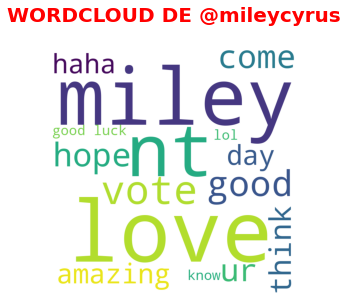

In [37]:
word_cloud(strCorpus1, top_3_mentions.Mentions[0], k)

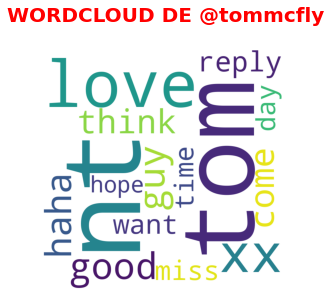

In [38]:
word_cloud(strCorpus2, top_3_mentions.Mentions[1], k)

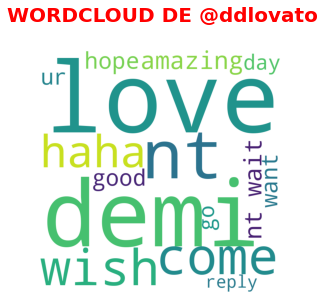

In [39]:
word_cloud(strCorpus3, top_3_mentions.Mentions[2], k)